In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import pylib as pl
from pylib import read_schism_hgrid, read_schism_bpfile, read_schism_vgrid, compute_zcor, chparam
from pylib import zdata, loadz, savez, ReadNC, WriteNC, read_schism_param, write_schism_param
import os
import shutil
import subprocess
import glob
# import dask
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gc
from functools import lru_cache
import warnings
from IPython.display import Video
warnings.filterwarnings('ignore')


In [2]:

# Change working directory (we need to create the models directory first and copy the required input files to it)
models_dir = '/Development/schism/schism_verification_tests/Test_WWM_limon_NODIF/'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
os.chdir(models_dir)

# Copy binary file
# shutil.copy('/Development/schism/binaries/pschism_AED_PREC_EVAP_BLD_STANDALONE_SH_MEM_COMM_TVD-VL', '/Development/schism/Pioneer_v_7_3D_local_data/')


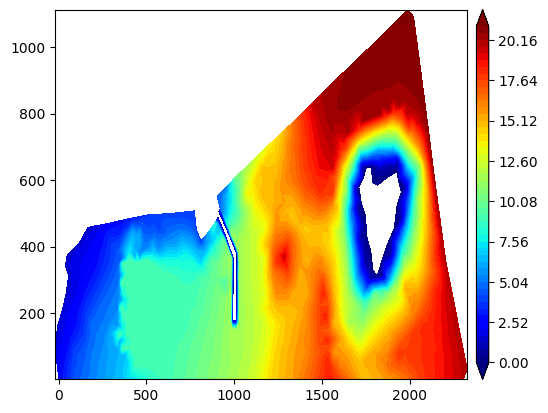

In [3]:
gd=read_schism_hgrid(os.path.join(models_dir,'hgrid.gr3'))
vd=read_schism_vgrid(os.path.join(models_dir,'vgrid.in'))
gd.plot(fmt=1)

In [4]:
# Go to the outputs directory
os.chdir(os.path.join(models_dir, 'outputs'))

# Detect the base variable name and collect matching files
base_var = "out2d"  # change this if needed
pattern = f"{base_var}_*.nc"
file_list = sorted(glob.glob(pattern))

if not file_list:
    raise FileNotFoundError(f"No files found matching {pattern}")

print(f"Found {len(file_list)} files for {base_var}")

# Start with first file
combined_ds = xr.open_dataset(file_list[0])

# Loop through the rest and concatenate
for f in file_list[1:]:
    ds = xr.open_dataset(f)
    combined_ds = xr.concat([combined_ds, ds], dim="time")

# Save combined result
combined_file = f"combined_{base_var}.nc"
combined_ds.to_netcdf(os.path.join(models_dir,'outputs',combined_file))

print(f"Combined file saved as {combined_file}")

Found 6 files for out2d
Combined file saved as combined_out2d.nc


In [6]:
out2d = xr.open_dataset(os.path.join(models_dir,'outputs','combined_out2d.nc'))
out2d.keys

<bound method Mapping.keys of <xarray.Dataset> Size: 101MB
Dimensions:                  (time: 360, one: 1, nSCHISM_hgrid_node: 1778,
                              nSCHISM_hgrid_face: 3328,
                              nMaxSCHISM_hgrid_face_nodes: 4,
                              nSCHISM_hgrid_edge: 5106, two: 2)
Coordinates:
  * time                     (time) datetime64[ns] 3kB 1998-09-01T00:01:00 .....
    SCHISM_hgrid_node_x      (nSCHISM_hgrid_node) float64 14kB ...
    SCHISM_hgrid_node_y      (nSCHISM_hgrid_node) float64 14kB ...
    SCHISM_hgrid_face_x      (nSCHISM_hgrid_face) float64 27kB ...
    SCHISM_hgrid_face_y      (nSCHISM_hgrid_face) float64 27kB ...
    SCHISM_hgrid_edge_x      (nSCHISM_hgrid_edge) float64 41kB ...
    SCHISM_hgrid_edge_y      (nSCHISM_hgrid_edge) float64 41kB ...
Dimensions without coordinates: one, nSCHISM_hgrid_node, nSCHISM_hgrid_face,
                                nMaxSCHISM_hgrid_face_nodes,
                                nSCHISM_hgrid_edge

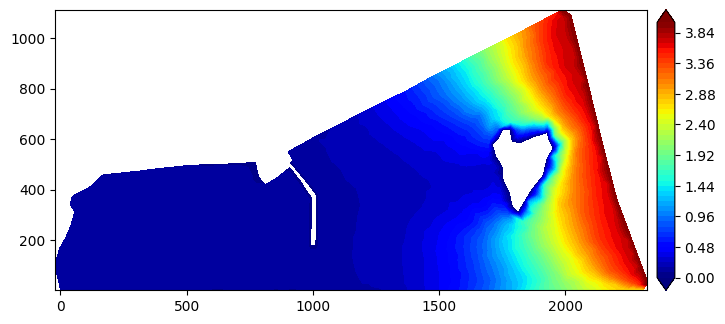

In [15]:
hs = out2d['sigWaveHeight']  # adjust dimension name if different

# Grid info
x = gd.x
y = gd.y
# --- Figure and axis setup ---
fig, ax = plt.subplots(figsize=(8, 4.5))

# 1. Initial plot (static first frame)
val = hs.isel(time=0).values.astype(np.float64)
im = gd.plot(fmt=1, value=val, ax=ax, cb=False)

ax.set_aspect('equal')
mesh = gd.plot(fmt=1, value=val, ticks=11, ax=ax, cb=False)
divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="3%", pad=0.1)  # same height as plot
cbar = plt.colorbar(mesh, cax=cax)
cbar.ax.tick_params(labelsize=10)
# ax.set_xticks([])
# ax.set_yticks([])
# ctx.add_basemap(ax, crs="EPSG:32755", source=ctx.providers.Esri.WorldImagery, attribution=False)

In [17]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gc
from IPython.display import Video
import numpy as np

# --- Extract variable ---
hs = out2d['sigWaveHeight']  # Significant wave height

# Grid info
x = gd.x
y = gd.y

# --- Figure and axis setup ---
fig, ax = plt.subplots(figsize=(8, 4.5))

# Initial frame (time = 0)
val = hs.isel(time=0).values.astype(np.float64)
mesh = gd.plot(fmt=1, value=val, ax=ax, cb=False)

ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
cbar = plt.colorbar(mesh, cax=cax)
cbar.ax.tick_params(labelsize=10)
ax.set_xticks([])
ax.set_yticks([])

# Fix colorbar scale across frames
vmin = float(hs.min())
vmax = float(hs.max())
mesh.set_clim(vmin, vmax)

# --- Update function ---
def update(frame):
    val = hs.isel(time=frame).values.astype(np.float64)
    mesh.set_array(val)  # update values
    ax.set_title(f"Significant Wave Height - {str(hs.time[frame].values)[:19]}")
    return mesh,

# --- Create animation ---
ani = animation.FuncAnimation(fig, update, frames=len(hs.time), interval=200, blit=True)

# --- Save animation ---
print("Saving animation (this will take a moment)...")
save_kwargs = {
    'writer': 'ffmpeg',
    'fps': 5,
    'extra_args': [
        '-vcodec', 'libx264',
        '-pix_fmt', 'yuv420p',
        '-profile:v', 'baseline',
        '-level', '3.0',
        '-crf', '23',
        '-preset', 'fast'
    ],
    'bitrate': 2000
}

try:
    ani.save("hs_animation.mp4", **save_kwargs)
    print("✓ hs_animation.mp4 saved successfully")
except Exception as e:
    print(f"⚠️ Save failed with optimized settings: {e}")
    print("Trying basic settings...")
    ani.save("hs_animation.mp4", writer="ffmpeg", fps=5)

# --- Cleanup ---
plt.close(fig)
del ani, mesh
gc.collect()

# --- Load video player ---
print("Loading video player...")
Video("hs_animation.mp4", width=800, height=450, embed=True)


Saving animation (this will take a moment)...
✓ hs_animation.mp4 saved successfully
Loading video player...
